In [51]:
import sys, os, re, pickle
import pandas as pd
from collections import defaultdict
from openbabel import openbabel as ob

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

os.getcwd()

'/net/pulsar/home/koes/mtr22/gan'

# Atom type analysis

Iterate through the Crossdock2020 dataset and display the distributions of atomic properties.

In [25]:
data_file = 'data/it2_tt_0_lowrmsd.types'
data_root = '/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output'
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [53]:
def getNumHydrogens(ob_atom):
    return ob_atom.GetTotalDegree() - ob_atom.GetHvyDegree()

funcs = [
    ob.OBAtom.GetAtomicNum, 
    ob.OBAtom.IsAromatic,
    ob.OBAtom.IsHbondAcceptor,
    ob.OBAtom.IsHbondDonor,
    ob.OBAtom.GetFormalCharge,
    getNumHydrogens,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [43]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]
    rec_src_no_ext = os.path.splitext(rec_src)[0]
    lig_src_no_ext = os.path.splitext(lig_src)[0]

    m = src_pat.match(rec_src_no_ext)
    rec_mol_base = m.group(1) + '.pdb'
    rec_idx = int(m.group(2))
    rec_mol_file = os.path.join(data_root, rec_mol_base)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[rec_idx]

    m = src_pat.match(lig_src_no_ext)
    lig_mol_base = m.group(1) + '.sdf'
    lig_idx = int(m.group(2))
    lig_mol_file = os.path.join(data_root, lig_mol_base)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[lig_idx]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

In [47]:
line_idx, n_lines, pct_done

(725033, 725033, 100.0)

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


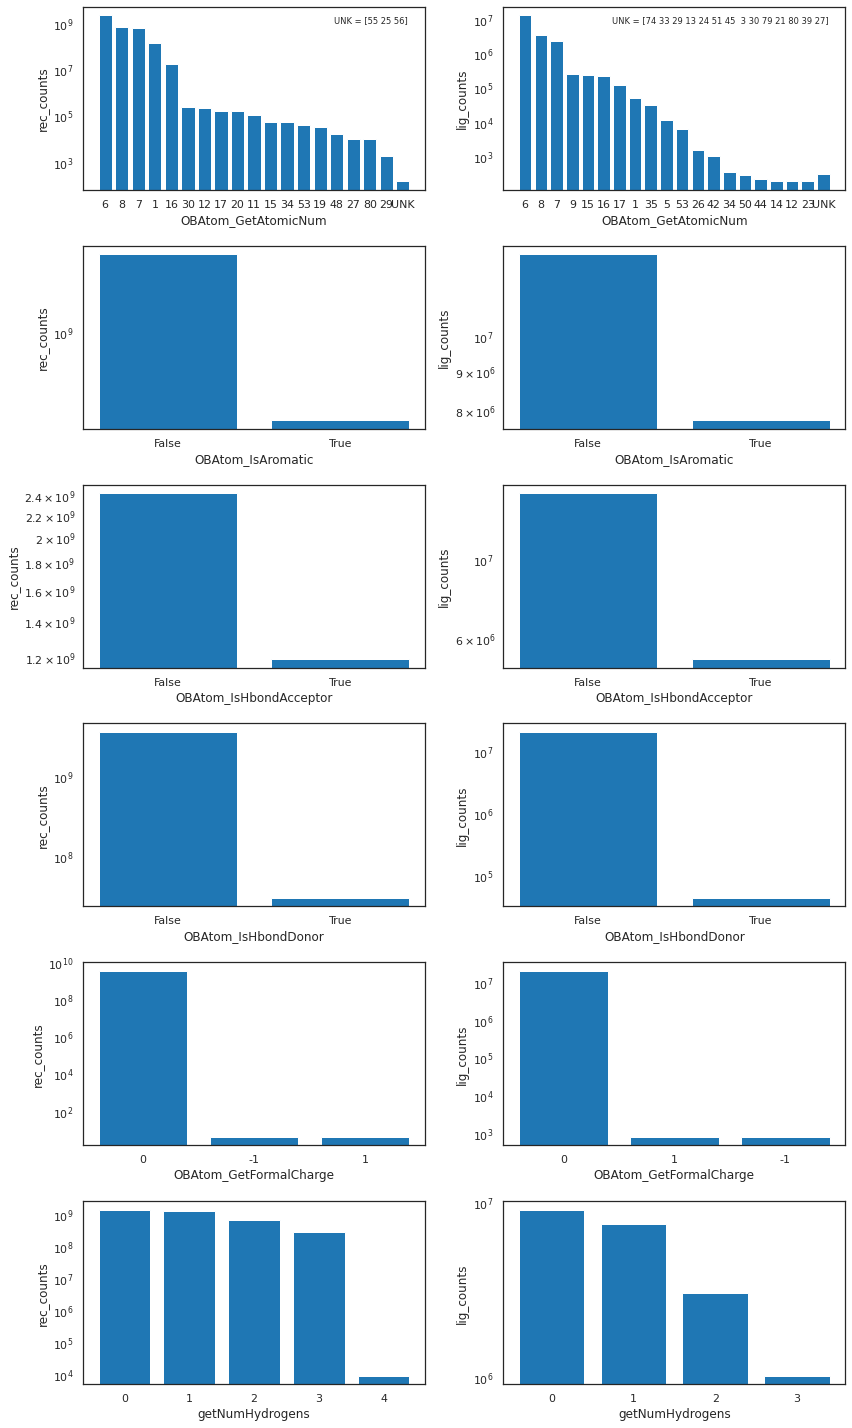

In [54]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)

def plot_counts(counts, ax, thresh=0.0, symbols=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by label
    idx = np.argsort(-counts)
    labels = labels[idx]
    counts = counts[idx]
    
    if symbols:
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    
    # apply threshold
    idx = (counts > thresh)
    n_unk = counts[~idx].sum()
    unk_labels = labels[~idx]

    if n_unk > 0 and len(labels) > 5:
        labels = labels[idx]
        counts = counts[idx]
        labels = np.append(labels, 'UNK')
        counts = np.append(counts, n_unk)
        
    # convert counts to percents
    #counts = counts / counts.sum()
    
    x = np.arange(len(counts))
    ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if 'UNK' in labels:
        ax.text(0.95, 0.95, 'UNK = {}'.format(unk_labels),
            fontsize='x-small',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
        )
    if len(labels) > 20:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')

fig, axes = plt.subplots(len(funcs), 2, figsize=(12, 20))

thresh = 100

for i, func in enumerate(funcs):
    ax = axes[i][0]
    plot_counts(rec_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('rec_counts')
    ax.set_yscale('log')

for i, func in enumerate(funcs):
    ax = axes[i][1]
    plot_counts(lig_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('lig_counts')
    ax.set_yscale('log')

fig.tight_layout()

In [138]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

1	H	0.31	1.1
6	C	0.76	1.7
7	N	0.71	1.55
8	O	0.66	1.52
11	Na	1.66	2.27
12	Mg	1.41	1.73
15	P	1.07	1.8
16	S	1.05	1.8
17	Cl	1.02	1.75
19	K	2.03	2.75
20	Ca	1.76	2.31
25	Mn	1.39	2.05
27	Co	1.26	2.0
29	Cu	1.32	2.0
30	Zn	1.22	2.1
34	Se	1.2	1.9
48	Cd	1.44	2.2
53	I	1.39	1.98
55	Cs	2.44	3.43
56	Ba	2.15	2.68
80	Hg	1.32	2.05


# Bond adding experiment

Test the ability to reconstruct molecules from atom types and coordinates by bond adding, using different atom typing schemes.

In [891]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

add_expt_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')
os.chdir(add_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing'

In [906]:
add_params = param_search.ParamSpace(
    data_root = '/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file = '/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples = 100000,
    typer_fns = ['oad', 'oadc', 'on', 'onc', 'oh'],
    use_ob_mol = [0, 1],
    remove_h = [0, 1],
)
len(add_params)

20

In [747]:
name_format = 'add_{typer_fns}_{use_ob_mol}_{remove_h}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_0_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_0_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_1_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_1_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_0_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_0_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_1_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_1_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_0_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_0_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_1_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_1_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_onc_0_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_onc_0_1/add.sh',
 '/net

In [748]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

[6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012]


In [892]:
import pandas as pd
add_df = pd.DataFrame(dict(
    job_id=[
        #[6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        #[6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        #[6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        #[6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        #[6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        #[6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        #[6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        #[6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        #[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
        #[6815396, 6815397, 6815398, 6815399, 6815400, 6815401, 6815402, 6815403, 6815404, 6815405, 6815406, 6815407, 6815408, 6815409, 6815410, 6815411, 6815412, 6815413, 6815414, 6815415],
        #[6815426, 6815427, 6815428, 6815429, 6815430, 6815431, 6815432, 6815433, 6815434, 6815435, 6815436, 6815437, 6815438, 6815439, 6815440, 6815441, 6815442, 6815443, 6815444, 6815445],
        #[6815523, 6815524, 6815525, 6815526, 6815527, 6815528, 6815529, 6815530, 6815531, 6815532, 6815533, 6815534, 6815535, 6815536, 6815537, 6815538, 6815539, 6815540, 6815541, 6815542],
        #[6815543, 6815544, 6815545, 6815546, 6815547, 6815548, 6815549, 6815550, 6815551, 6815552, 6815553, 6815554, 6815555, 6815556, 6815557, 6815558, 6815559, 6815560, 6815561, 6815562],
        #[6815565, 6815566, 6815567, 6815568, 6815569, 6815570, 6815571, 6815572, 6815573, 6815574, 6815575, 6815576, 6815577, 6815578, 6815579, 6815580, 6815581, 6815582, 6815583, 6815584],
        #[6815588, 6815589, 6815590, 6815591, 6815592, 6815593, 6815594, 6815595, 6815596, 6815597, 6815598, 6815599, 6815600, 6815601, 6815602, 6815603, 6815604, 6815605, 6815606, 6815607],
        [6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [893]:
import numpy as np
import glob, re
import param_search

qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

add_df = add_df.merge(qstat, on='job_id', how='left')

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

add_df['work_dir'] = add_df.apply(find_work_dir, axis=1)
add_df['job_name'] = add_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_df['job_file'] = add_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
add_df['stdout_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_df['stderr_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
add_df['stdout'] = add_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
add_df['stderr'] = add_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
add_df['job_state'] = add_df.apply(find_job_state, axis=1)

add_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stdout', 'stderr']]

,,runtime,node_id,job_state,stdout,stderr
job_id,job_name,,,,,
6816993,add_oad_0_0,NaN,NaN,OK,None,None
6816994,add_oad_0_1,NaN,NaN,OK,None,None
6816995,add_oad_1_0,NaN,NaN,OK,None,None
6816996,add_oad_1_1,NaN,NaN,OK,None,None
6816997,add_oadc_0_0,NaN,NaN,OK,None,None
6816998,add_oadc_0_1,NaN,NaN,OK,None,None
6816999,add_oadc_1_0,NaN,NaN,OK,None,None
6817000,add_oadc_1_1,NaN,NaN,OK,None,None
6817001,add_on_0_0,NaN,NaN,OK,None,None


In [894]:
pd.set_option('display.max_columns', 100)
add_metrics = param_search.metrics(add_job_files, metric_pat='(.*)metrics')
add_metrics.groupby(['job_name'])[['example_idx']].count()

,example_idx
job_name,
add_oad_0_0,100000
add_oad_0_1,100000
add_oad_1_0,100000
add_oad_1_1,100000
add_oadc_0_0,100000
add_oadc_0_1,100000
add_oadc_1_0,100000
add_oadc_1_1,100000
add_oh_0_0,87115


In [895]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[
    (plot_df['remove_h'] == 0) &
    (plot_df['typer_fns'] == 'on')
]
plot_df.groupby(
    ['use_ob_mol', 'lig_reason']
)[['lig_name']].count().unstack() / 100000 * 100

lig_name               
lig_reason invalid valence valid molecule
use_ob_mol                               
0                    8.556         91.444
1                    8.556         91.444

oad  = H acceptor/donor
oadc = H acceptor/donor + formal charge
on   = H count
onc  = H count + formal charge
oh   = explicit H atoms


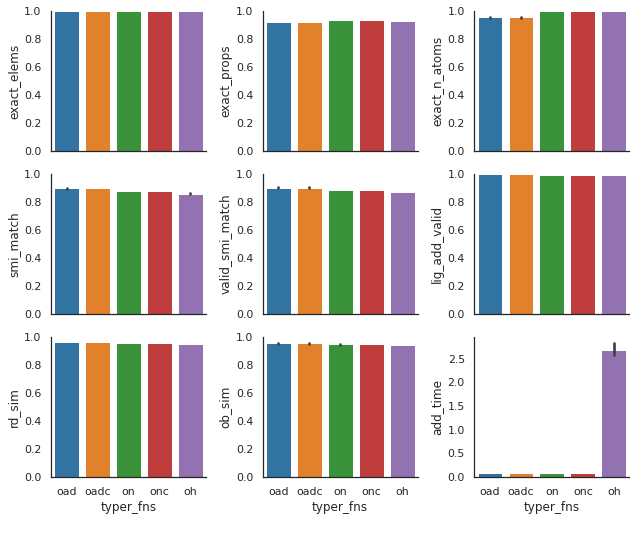

In [896]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='H count',
    onc ='H count + formal charge',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        'smi_match',
        'valid_smi_match',
        'lig_add_valid',
        'rd_sim',
        'ob_sim',
        'add_time'
    ],
    hue=None,
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=sns.barplot,
    ylim=dict(
        exact_elems=[0, 1],
        exact_props=[0, 1],
        exact_n_atoms=[0, 1],
        smi_match=[0, 1],
        lig_valid=[0, 1],
        lig_add_valid=[0, 1],
        valid_smi_match=[0, 1],
        rd_sim=[0, 1],
        ob_sim=[0, 1],
    )
)

print('\n'.join(
    '{} = {}'.format(tf.ljust(4), typer_fn_map[tf]) for tf in ['oad', 'oadc', 'on', 'onc', 'oh']
))

In [897]:
plot_df.groupby(['typer_fns'])[
    ['exact_elems', 'exact_props', 'exact_n_atoms', 'smi_match', 'lig_valid', 'lig_add_valid', 'valid_smi_match', 'rd_sim', 'ob_sim', 'add_time']
].mean() * 100

,exact_elems,exact_props,exact_n_atoms,smi_match,lig_valid,lig_add_valid,valid_smi_match,rd_sim,ob_sim,add_time
typer_fns,,,,,,,,,,
oad,100.0,91.950265,95.175189,89.561918,100.0,99.556012,89.961335,95.862544,95.119493,7.462372
oadc,100.0,91.994007,95.218932,89.605660,100.0,99.556012,90.005273,95.880239,95.138715,7.459011
oh,100.0,92.743515,100.000000,85.728539,100.0,98.822290,86.750205,94.929347,93.787232,265.402777
on,100.0,93.187087,100.000000,87.518044,100.0,99.128428,88.287533,95.449100,94.414024,7.398175
onc,100.0,93.193649,100.000000,87.561786,100.0,99.128428,88.331660,95.465724,94.434357,7.216748


In [898]:
reasons = plot_df['lig_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

,valid molecule
typer_fns,
oad,100
oadc,100
oh,100
on,100
onc,100


In [899]:
reasons = plot_df['lig_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_add_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

,valid molecule,invalid valence,multiple fragments
typer_fns,,,
oad,99.556012,0.443988,0.00000
oadc,99.556012,0.443988,0.00000
oh,98.822290,1.049340,0.12837
on,99.128428,0.871572,0.00000
onc,99.128428,0.871572,0.00000


In [890]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

plot_df[
    (plot_df['use_ob_mol'] == 0) &
    (plot_df['remove_h'] == 0) & 
    (plot_df['typer_fns'] == 'on') &
    (plot_df['exact_elems'] == 1) &
    (plot_df['exact_props'] == 1) &
    (plot_df['exact_n_atoms'] == 1) &
    (plot_df['smi_match'] == 0)
]

,index,example_idx,lig_name,pose_idx,elem_count_diff,prop_count_diff,n_atoms_diff,lig_smi,lig_valid,lig_reason,lig_add_smi,lig_add_valid,lig_add_reason,smi_match,rd_sim,ob_sim,add_time,data_root,data_file,n_examples,typer_fns,use_ob_mol,remove_h,job_name,exact_elems,exact_props,exact_n_atoms,valid_smi_match
800002,2,2,3el8_B_rec_4fic_0ul_lig_tt_docked,13,0,0,0,NC1=NC2C=NC(c3ccccc3)=CN2N1,True,valid molecule,NC1=NC2[CH]N=C(c3ccccc3)[CH]N2N1,True,valid molecule,False,0.3817,0.3316,0.0262,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
800003,3,3,3rwq_A_rec_3qcq_3q0_lig_tt_docked,0,0,0,0,CCNc1cc(C2=CC3=NN=C(N)C3=CC2)nc(N)n1,True,valid molecule,CCNc1cc(C2=CC3=C([CH]C2)[C](N)N=N3)nc(N)n1,True,valid molecule,False,0.5910,0.4957,0.0398,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
800010,10,10,1c88_A_rec_3cwe_825_lig_tt_min,0,0,0,0,O=C(c1ccccc1)C(Cc1ccc(C(F)(F)P(=O)(O)O)c(Br)c1...,True,valid molecule,OC(F)(F)(c1c(Br)cc(CC(C(=O)c2ccccc2)c2ccccc2)c...,False,invalid valence,False,NaN,NaN,0.0706,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,NaN
800054,54,54,4kbn_A_rec_5hsr_63y_lig_tt_docked,18,0,0,0,FC1=C(F)C2C3(C(=S)C1)C14SC1CC(F)=C(F)C243,True,valid molecule,[C]CC(F)=C(F)C([C]SC#C)[C]1SCC(F)=C1F,True,valid molecule,False,0.5117,0.4419,0.0372,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
800077,77,77,3cov_A_rec_3iub_fg2_lig_tt_min,0,0,0,0,COC1=CCC2=NC(C(=O)NS(=O)(=O)c3ccc(C)cn3)=CC2=C1,True,valid molecule,COC1=CC2=C(C[CH]1)N=C(C(=O)NS(=O)(=O)c1ccc(C)c...,True,valid molecule,False,0.5912,0.5037,0.0450,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899921,99921,99921,3unc_B_rec_3unc_mos_lig_tt_docked,0,0,0,0,O[Mo](O)S,True,valid molecule,O[SH][OH][Fe],False,invalid valence,False,NaN,NaN,0.0040,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,NaN
899928,99928,99928,5uwm_A_rec_5boy_4ue_lig_tt_docked,0,0,0,0,CCOC(=O)C1=NC2C=CC(c3cncn3C)=CC2=C1,True,valid molecule,CCOC(=O)C1=NC2C=C[C](c3cncn3C)C=C2[CH]1,True,valid molecule,False,0.5496,0.5256,0.0373,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
899940,99940,99940,4ajf_A_rec_5edh_5mf_lig_tt_docked,2,0,0,0,CCC1=C2N=C(CCc3nc(N4CCCC4)nn3C)NN2C(C)N=C1,True,valid molecule,CCC1=C[N]C(C)N2N[C](CCc3nc(N4CCCC4)nn3C)N=C12,True,valid molecule,False,0.6550,0.6038,0.0571,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
899986,99986,99986,4bzn_A_rec_4wt6_3u6_lig_tt_docked,1,0,0,0,Nc1nnc(-c2ccc3c(c2)=C(c2cccc(NC4CCCC4)n2)CN=3)s1,True,valid molecule,Nc1nnc(-c2ccc3c(c2)[C](c2cccc(NC4CCCC4)n2)C[N]...,True,valid molecule,False,0.5588,0.5874,0.0666,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0


# Atom fitting experiment

Test the ability to reconstruct molecules from atoms that were fit to atomic density grids, through atom fitting + bond adding, using the different typing schemes.

In [900]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

fit_expt_dir = os.path.join(add_expt_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting'

In [754]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)
len(fit_params)

12

In [755]:
name_format = 'fit_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-1.0_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-1.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-1.0_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-1.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-1.0_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-1.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oh-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oh-1.0_0/generate.sh',
 

In [756]:
job_ids = param_search.submit(fit_job_files)
print(job_ids)

[6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024]


In [901]:
import pandas as pd
fit_df = pd.DataFrame(dict(
    job_id=[
        #[6814426, 6814427, 6814428, 6814429, 6814430, 6814431, 6814432, 6814433, 6814434, 6814435, 6814436, 6814437, 6814438, 6814439, 6814440, 6814441],
        #[6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457],
        [6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [902]:
import numpy as np
import glob, re
import param_search

qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

fit_df = fit_df.merge(qstat, on='job_id', how='left')
fit_df['work_dir'] = fit_df.apply(find_work_dir, axis=1)
fit_df['job_name'] = fit_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
fit_df['job_file'] = fit_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
fit_df['stdout_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
fit_df['stderr_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
fit_df['stdout'] = fit_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
fit_df['stderr'] = fit_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
fit_df['job_state'] = fit_df.apply(find_job_state, axis=1)

fit_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stderr']]

,,runtime,node_id,job_state,stderr
job_id,job_name,,,,
6817013,fit_oad-0.5_0,2-16:54:56,g007,R,None
6817014,fit_oad-1.0_0,2-16:54:56,g007,R,None
6817015,fit_oad-1.5_0,2-16:54:56,g007,R,None
6817016,fit_oadc-0.5_0,2-16:54:56,g001,R,None
6817017,fit_oadc-1.0_0,2-16:54:56,g002,R,None
6817018,fit_oadc-1.5_0,2-16:54:56,g002,R,None
6817019,fit_on-0.5_0,2-16:54:56,g002,R,None
6817020,fit_on-1.0_0,2-16:54:56,g003,R,None
6817021,fit_on-1.5_0,2-16:54:56,g003,R,None


In [903]:
fit_metrics = param_search.metrics(fit_job_files, metric_pat='(.*)metrics')
fit_metrics.groupby(['job_name'])[['sample_idx']].count()

,sample_idx
job_name,
fit_oad-0.5_0,42910
fit_oad-1.0_0,42900
fit_oad-1.5_0,42010
fit_oadc-0.5_0,39150
fit_oadc-1.0_0,39460
fit_oadc-1.5_0,38300
fit_oh-0.5_0,35810
fit_oh-1.0_0,36670
fit_oh-1.5_0,36160


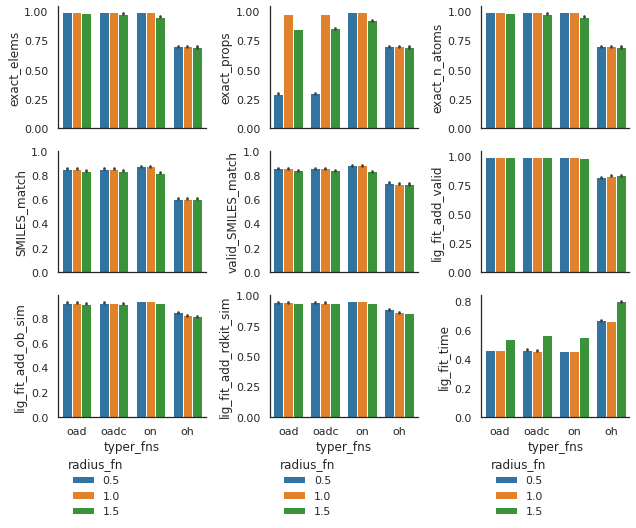

In [904]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

def my_plot(*args, **kwargs):
    return sns.barplot(*args, **kwargs)

plot_df = fit_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid mols
plot_df['exact_elems'] = (plot_df['lig_fit_elem_diff'] == 0)
plot_df['exact_props'] = (plot_df['lig_fit_prop_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['lig_fit_add_n_atoms_diff'] == 0)
plot_df['SMILES_match'] = plot_df['lig_fit_add_SMILES_match']
plot_df['valid_SMILES_match'] = plot_df['lig_fit_add_SMILES_match'].where(plot_df['lig_valid'] & plot_df['lig_fit_add_valid'])

fig = param_search.plot(
    plot_df, #[plot_df['radius_fn'] == 'c'],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        
        'SMILES_match',
        'valid_SMILES_match',
        'lig_fit_add_valid',
        
        'lig_fit_add_ob_sim',
        'lig_fit_add_rdkit_sim',
        'lig_fit_time',
    ],
    hue='radius_fn',
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=my_plot,
    ylim=dict(SMILES_match=[0,1], valid_SMILES_match=[0,1])
)

In [905]:
plot_df = fit_metrics.reset_index()
reasons = plot_df['lig_fit_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_fit_add_reason'] == r)

plot_df.groupby(['typer_fns', 'radius_fn'])[reasons].mean() * 100

valid molecule  invalid valence  multiple fragments
typer_fns radius_fn                                                     
oad       0.5             99.494290         0.501049            0.004661
          1.0             99.240093         0.757576            0.002331
          1.5             99.316829         0.683171            0.000000
oadc      0.5             99.542784         0.454662            0.002554
          1.0             99.303092         0.696908            0.000000
          1.5             99.315927         0.673629            0.010444
oh        0.5             80.809830        16.163083            3.027087
          1.0             82.020725        15.950368            2.028906
          1.5             82.422566        17.284292            0.293142
on        0.5             98.238541         1.759059            0.002400
          1.0             98.252170         1.747830            0.000000
          1.5             97.768721         2.228732            0.002547

130

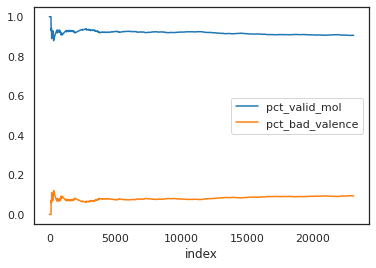

In [862]:
plot_df = fit_metrics.reset_index()
plot_df = plot_df[plot_df['job_name'] == 'fit_on-1.0_0']

plot_df['n_mols'] = plot_df['index'] + 1
plot_df['pct_valid_mol'] = plot_df['lig_valid'].cumsum() / plot_df['n_mols']
plot_df['pct_bad_valence'] = (plot_df['lig_reason'] == 'invalid valence').cumsum() / plot_df['n_mols']

plot_df.plot(x='index', y=['pct_valid_mol', 'pct_bad_valence'])

fit_metrics[fit_metrics['lig_valid']].groupby('job_name')
first_invalid_idx = plot_df[plot_df['lig_valid'] == False]['index'].iloc[0]
first_invalid_idx

13

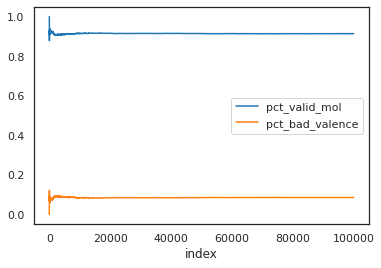

In [863]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[
    (plot_df['job_name'] == 'add_on_0_0') &
    (plot_df['index'] <= 100000)
]

plot_df['n_mols'] = plot_df['index'] + 1
#plot_df['index'] = np.random.permutation(len(plot_df)) # shuffle order
plot_df['pct_valid_mol'] = plot_df['lig_valid'].cumsum() / plot_df['n_mols']
plot_df['pct_bad_valence'] = (plot_df['lig_reason'] == 'invalid valence').cumsum() / plot_df['n_mols']

plot_df.plot(x='index', y=['pct_valid_mol', 'pct_bad_valence'])

fit_metrics[fit_metrics['lig_valid']].groupby('job_name')
first_invalid_idx = plot_df[plot_df['lig_valid'] == False]['index'].iloc[0]
first_invalid_idx

In [681]:
plot_df[plot_df['lig_reason'] == 'failed to kekulize']['lig_name'].sample(frac=0.1)

869171       1s3v_A_rec_1u71_mxa_lig_tt_min
872206    4qhv_A_rec_1dls_mtx_lig_tt_docked
868736       1pdb_A_rec_2dhf_dzf_lig_tt_min
839581       5t4u_A_rec_5e3g_5jq_lig_tt_min
875293       3mo0_B_rec_3mo2_e67_lig_tt_min
                        ...                
834799       5d24_A_rec_4o7f_2rq_lig_tt_min
833857       5d3r_A_rec_4o7b_2rj_lig_tt_min
869362       1pdb_A_rec_1u71_mxa_lig_tt_min
849585       2i7q_A_rec_3f2r_hc6_lig_tt_min
832870       4nuc_A_rec_4o7f_2rq_lig_tt_min
Name: lig_name, Length: 706, dtype: object

In [714]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[
    (plot_df['use_ob_mol'] == 0) & (plot_df['remove_h'] == 0)
]
plot_df = plot_df.pivot(
    index=['example_idx', 'lig_name', 'pose_idx'],
    columns='typer_fns',
    values=['lig_valid', 'lig_reason', 'lig_add_valid', 'lig_add_reason']
)
plot_df[plot_df['lig_add_valid']['oadc'] & ~plot_df['lig_add_valid']['on']][['lig_reason', 'lig_add_reason']]

lig_reason  \
typer_fns                                                              oad   
example_idx lig_name                          pose_idx                       
1541        3zlv_A_rec_2ha6_sck_lig_tt_min    0         failed to kekulize   
1542        4b83_A_rec_1j07_dcu_lig_tt_min    0         failed to kekulize   
1544        3dl7_A_rec_2ha3_cht_lig_tt_min    0         failed to kekulize   
1547        5ov9_A_rec_2ha4_ach_lig_tt_min    0         failed to kekulize   
1548        2gyw_B_rec_2ha5_at3_lig_tt_min    0         failed to kekulize   
...                                                                    ...   
97984       2xef_A_rec_3bi1_3bi_lig_tt_docked 2             valid molecule   
99630       3kbo_A_rec_3kbo_ndb_lig_tt_docked 6         failed to kekulize   
99631       3kbo_A_rec_3kbo_ndb_lig_tt_docked 10        failed to kekulize   
99632       3kbo_A_rec_3kbo_ndb_lig_tt_min    0         failed to kekulize   
99633       3pp8_A_rec_3kbo_ndb_lig_tt_min    0         failed to kekulize   

                                                                            \
typer_fns                                                             oadc   
example_idx lig_name                          pose_idx                       
1541        3zlv_A_rec_2ha6_sck_lig_tt_min    0         failed to kekulize   
1542        4b83_A_rec_1j07_dcu_lig_tt_min    0         failed to kekulize   
1544        3dl7_A_rec_2ha3_cht_lig_tt_min    0         failed to kekulize   
1547        5ov9_A_rec_2ha4_ach_lig_tt_min    0         failed to kekulize   
1548        2gyw_B_rec_2ha5_at3_lig_tt_min    0         failed to kekulize   
...                                                                    ...   
97984       2xef_A_rec_3bi1_3bi_lig_tt_docked 2             valid molecule   
99630       3kbo_A_rec_3kbo_ndb_lig_tt_docked 6         failed to kekulize   
99631       3kbo_A_rec_3kbo_ndb_lig_tt_docked 10        failed to kekulize   
99632       3kbo_A_rec_3kbo_ndb_lig_tt_min    0         failed to kekulize   
99633       3pp8_A_rec_3kbo_ndb_lig_tt_min    0         failed to kekulize   

                                                                            \
typer_fns                                                               oh   
example_idx lig_name                          pose_idx                       
1541        3zlv_A_rec_2ha6_sck_lig_tt_min    0         failed to kekulize   
1542        4b83_A_rec_1j07_dcu_lig_tt_min    0         failed to kekulize   
1544        3dl7_A_rec_2ha3_cht_lig_tt_min    0         failed to kekulize   
1547        5ov9_A_rec_2ha4_ach_lig_tt_min    0         failed to kekulize   
1548        2gyw_B_rec_2ha5_at3_lig_tt_min    0         failed to kekulize   
...                                                                    ...   
97984       2xef_A_rec_3bi1_3bi_lig_tt_docked 2                        NaN   
99630       3kbo_A_rec_3kbo_ndb_lig_tt_docked 6                        NaN   
99631       3kbo_A_rec_3kbo_ndb_lig_tt_docked 10                       NaN   
99632       3kbo_A_rec_3kbo_ndb_lig_tt_min    0                        NaN   
99633       3pp8_A_rec_3kbo_ndb_lig_tt_min    0                        NaN   

                                                                            \
typer_fns                                                               on   
example_idx lig_name                          pose_idx                       
1541        3zlv_A_rec_2ha6_sck_lig_tt_min    0         failed to kekulize   
1542        4b83_A_rec_1j07_dcu_lig_tt_min    0         failed to kekulize   
1544        3dl7_A_rec_2ha3_cht_lig_tt_min    0         failed to kekulize   
1547        5ov9_A_rec_2ha4_ach_lig_tt_min    0         failed to kekulize   
1548        2gyw_B_rec_2ha5_at3_lig_tt_min    0         failed to kekulize   
...                                                                    ...   
97984       2xef_A_rec_3bi1_3bi_lig_tt_docked 2             valid molecule   
99630

# Training experiment
Train generative models to produce atomic density grids, then test molecule reconstruction using atom fitting + bond adding.

In [864]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

train_expt_dir = os.path.join(add_expt_dir, 'training')
os.chdir(train_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

In [316]:
train_params = param_search.ParamSpace(
    random_seed=[0,1,2],
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols.types',
    model_type=['CVAE', 'CVAEGAN'],
    typer_fns=['oadc', 'on'],
    radius_fn=['v', 'c'],
    n_latent=[1024, 256, 128],
    gen_spectral_norm=[0, 1],
    optim_type='RMSprop',
    gen_lr=1e-5,
    disc_lr=1e-4,
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    n_disc_train_iters=2,
)
len(train_params)

144

In [326]:
name_format = 'train_{model_type}_{typer_fns}-{radius_fn}_{n_latent}_{gen_spectral_norm}_{random_seed}'

for template_file in ['train.config', 'train.sh']:
    train_job_files = param_search.setup(
        expt_dir=train_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=train_params,
    )

train_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_1024_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_1024_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_256_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_256_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_128_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_128_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_1024_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_1024_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_256_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_256_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/ne

In [319]:
job_ids = param_search.submit(train_job_files)
print(job_ids)

[6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 

In [865]:
import pandas as pd
train_df = pd.DataFrame(dict(
    job_id=[
        [6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 6814644, 6814645, 6814646, 6814647, 6814648, 6814649, 6814650, 6814651, 6814652, 6814653, 6814654, 6814655, 6814656, 6814657, 6814658, 6814659, 6814660, 6814661, 6814662, 6814663, 6814664, 6814665, 6814666, 6814667, 6814668, 6814669, 6814670, 6814671, 6814672, 6814673, 6814674, 6814675, 6814676],
        #
    ]
)).explode('job_id')

In [866]:
import numpy as np
import glob, re
import param_search

qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

train_df = train_df.merge(qstat, on='job_id', how='left')
train_df['work_dir'] = train_df.apply(find_work_dir, axis=1)
train_df['job_name'] = train_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
train_df['job_file'] = train_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
train_df['stdout_file'] = train_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
train_df['stderr_file'] = train_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
train_df['stdout'] = train_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
train_df['stderr'] = train_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
train_df['job_state'] = train_df.apply(find_job_state, axis=1)

train_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stdout', 'stderr']]

,,runtime,node_id,job_state,stdout,stderr
job_id,job_name,,,,,
6814533,train_CVAE_oadc-v_1024_0_0,NaN,NaN,OK,[iteration=10000 data_phase=train] loss=705.63...,None
6814534,train_CVAE_oadc-v_1024_1_0,NaN,NaN,ERR,[iteration=99 data_phase=train] loss=1554.9977...,RuntimeError: CUDA out of memory. Tried to all...
6814535,train_CVAE_oadc-v_256_0_0,NaN,NaN,OK,[iteration=10000 data_phase=train] loss=700.02...,None
6814536,train_CVAE_oadc-v_256_1_0,NaN,NaN,OK,[iteration=10000 data_phase=train] loss=516.68...,None
6814537,train_CVAE_oadc-v_128_0_0,NaN,NaN,OK,[iteration=10000 data_phase=train] loss=725.59...,None
...,...,...,...,...,...,...
6814672,train_CVAEGAN_on-c_1024_1_2,NaN,NaN,ERR,None,RuntimeError: CUDA Error: no kernel image is a...
6814673,train_CVAEGAN_on-c_256_0_2,NaN,NaN,ERR,None,RuntimeError: CUDA Error: no kernel image is a...
6814674,train_CVAEGAN_on-c_256_1_2,NaN,NaN,ERR,None,RuntimeError: CUDA Error: no kernel image is a...


In [867]:
train_metrics = param_search.metrics(train_job_files, metric_pat='(.*)metrics')
train_metrics.groupby(['job_name'])[['iteration']].max()

/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_1024_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_1024_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_1024_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_256_0_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_256_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_128_0_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_128_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-c_1024_0_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_C

,iteration
job_name,
train_CVAEGAN_oadc-c_1024_0_0,500
train_CVAEGAN_oadc-c_1024_0_1,500
train_CVAEGAN_oadc-c_1024_1_0,0
train_CVAEGAN_oadc-c_1024_1_1,500
train_CVAEGAN_oadc-c_128_0_0,500
...,...
train_CVAE_on-v_1024_1_0,0
train_CVAE_on-v_128_0_0,10000
train_CVAE_on-v_128_1_0,10000


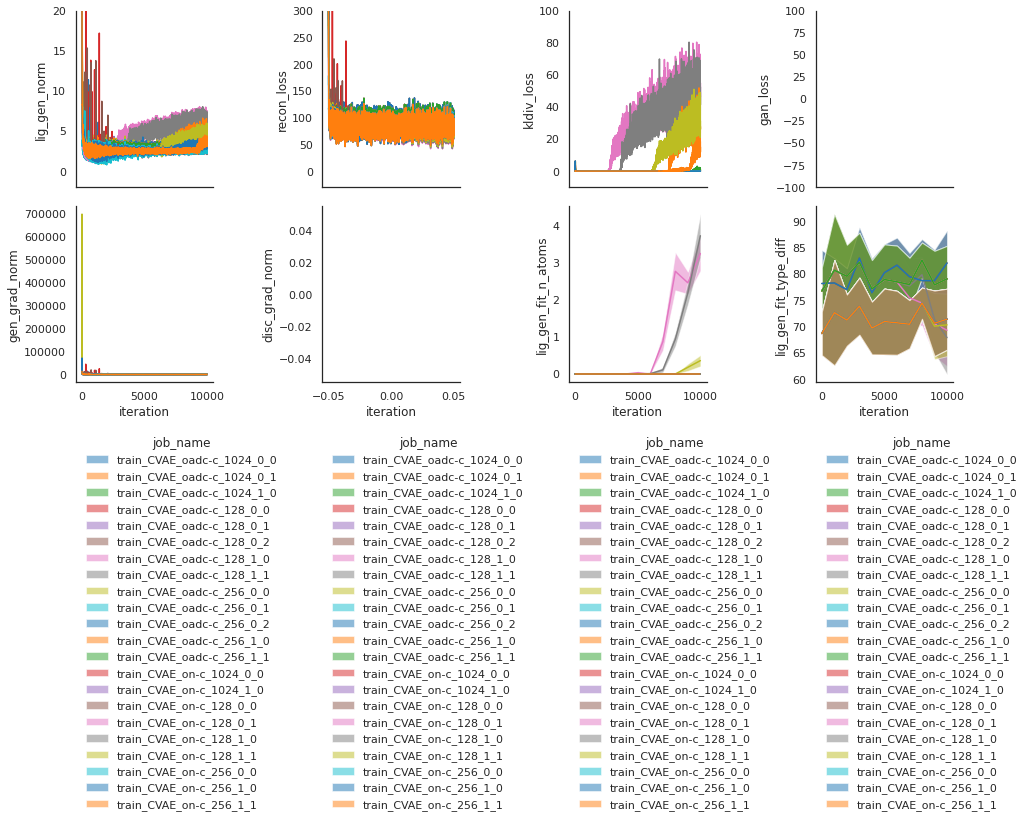

In [868]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_context('notebook')

def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def my_plot(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plot_df = train_metrics.reset_index()

fig = param_search.plot(
    plot_df[
        (plot_df['model_phase'] != 'disc') &
        (plot_df['model_type'] == 'CVAE') &
        (plot_df['radius_fn'] == 'c')
    ],
    x='iteration',
    y=[
        'lig_gen_norm',
        'recon_loss',
        'kldiv_loss',
        'gan_loss',
        'gen_grad_norm',
        'disc_grad_norm',
        'lig_gen_fit_n_atoms',
        'lig_gen_fit_type_diff'
    ],
    hue='job_name',
    n_cols=4,
    width=3.5,
    height=6,
    plot_func=my_plot,
    ylim=dict(
        lig_gen_norm=[-2, 20],
        recon_loss=[-30, 300],
        kldiv_loss=[-10, 100],
        gan_loss=[-100, 100],
    )
)

In [742]:
train_metrics.columns

Index(['iteration', 'data_phase', 'batch', 'loss', 'recon_loss', 'kldiv_loss',
       'lig_norm', 'lig_variance', 'lig_gen_norm', 'lig_gen_variance',
       'lig_gen_L2_loss', 'lig_gen_fit_n_atoms', 'lig_gen_fit_radius',
       'lig_n_atoms', 'lig_radius', 'lig_gen_fit_type_diff',
       'lig_gen_fit_exact_types', 'lig_gen_fit_atom_rmsd', 'forward_data_time',
       'forward_gen_time', 'forward_fit_time', 'forward_metrics_time',
       'forward_time', 'forward_gpu', 'memory', 'gen_grad_norm',
       'backward_time', 'backward_grad_time', 'backward_norm_time',
       'backward_update_time', 'backward_gpu', 'random_seed', 'data_root',
       'train_file', 'test_file', 'model_type', 'typer_fns', 'radius_fn',
       'n_latent', 'gen_spectral_norm', 'optim_type', 'gen_lr', 'disc_lr',
       'gen_grad_clip', 'disc_grad_clip', 'n_gen_train_iters',
       'n_disc_train_iters', 'job_name', 'disc_iter', 'model_phase',
       'grid_phase', 'gan_loss', 'pred_mean', 'pred_variance',
       'forward